In [1]:
import torch
import torchvision
import torch.nn as nn
import spikingjelly
from spikingjelly.activation_based import ann2snn
from tqdm import tqdm
from spikingjelly.activation_based.ann2snn.examples import cnn_mnist as snn 
from spikingjelly.activation_based.ann2snn.sample_models import mnist_cnn
from spikingjelly.activation_based import neuron
from spikingjelly.activation_based.ann2snn.examples.loader import CustomLoader
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

### **Task 1** is installing all prerequisites correctly so that the following imports run smoothly. (10 marks)

Install the correct version of torch if you wish to use CUDA.

Install the spikingjelly using the setup.py file only and not with pip using the command 'python setup.py install'.

Note:
1. Exact command used for installing spikingjelly: python setup.py install --user
2. doing pip install for requests module (did not auto install from the setup script - not specified in the requirements either)

In [2]:
# set Hyperparameters
snn.hyperparameters.T = 20
snn.hyperparameters.batch_size = 100

device = 'cuda' # use 'cpu' if CUDA not available
download_dataset = True # downloads MNIST
dataset_dir = './spikingjelly/datasets/mnist'
download_model = False # downloads a 3 layer CNN classifier

if download_model:
        print('Downloading SJ-mnist-cnn_model-sample.pth...')
        ann2snn.download_url("https://ndownloader.figshare.com/files/34960191", './SJ-mnist-cnn_model-sample.pth')

model = mnist_cnn.CNN().to(device)
model.load_state_dict(torch.load('SJ-mnist-cnn_model-sample.pth'))
print(model)

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [3]:
test_data_dataset = torchvision.datasets.MNIST(
    root=dataset_dir,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_data_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=False
)


We see the specification of our CNN, having three Conv blocks with [Conv, BatchNorm2d, ReLU, AvgPool2d] modules.

## **Task 2** is calculating the number of MAC operations in each Conv layer. (10 Marks)


Below we take the first two Conv blocks (first 8 modules) as a backbone and the rest of the model as the head.

We freeze the backbone, convert the head to an SNN and evaluate using snn.main.

### Logic for calculating number of MAC operations:
*   m1 = Num of MACs per ip channel for each op channel = [floor( (ip_rows - filter_rows) / stride ) + 1] * [floor( (ip_columns - filter_columns) / stride ) + 1] * Kernal_rows * Kernal_columns
*   m2 = Num of MACs per op channel = m1 * number of input channels
*   m3 = Number of MACs per conv layer = m2 * Num of op channels

m3 is the required answer

In [ ]:
#Calculating MAC operations
def calculate_mac(network, initial_size=28):
    """
    m1 = Output Feature Map Size * K*K
    m2 = m1 * C_in (Input Channels)
    m3 = m2 * C_out (Output Channels)
    """
    current_h = initial_size
    current_w = initial_size
    results = {}

    for i, layer in enumerate(network.children()):
        if isinstance(layer, (nn.Conv2d, nn.AvgPool2d, nn.MaxPool2d)):
            
            kernel_size = layer.kernel_size if hasattr(layer, 'kernel_size') else 1
            kernel_size = kernel_size[0] if isinstance(kernel_size, tuple) else kernel_size
            # kernel_size = kernel_size[0]
            
            stride = layer.stride if hasattr(layer, 'stride') else 1
            stride = stride[0] if isinstance(stride, tuple) else stride

            padding = layer.padding if hasattr(layer, 'padding') else 0
            padding = padding[0] if isinstance(padding, tuple) else padding
            
            # --- Calculate Output Spatial Dimensions ---
            h_out = math.floor((current_h - kernel_size + 2 * padding) / stride) + 1
            w_out = math.floor((current_w - kernel_size + 2 * padding) / stride) + 1
            
            if isinstance(layer, nn.Conv2d):
                # --- Calculate MAC Breakdown (m1, m2, m3) ---
                C_in = layer.in_channels
                C_out = layer.out_channels                
                m1_output_size = h_out * w_out
                m1 = m1_output_size * (kernel_size * kernel_size)                
                m2 = m1 * C_in                
                m3 = m2 * C_out
                
                results[f'Layer ({i})'] = {
                    'm1': int(m1),
                    'm2': int(m2),
                    'm3': int(m3)
                }
            
            # --- Update Spatial Dimensions for the Next Layer ---
            current_h = h_out
            current_w = w_out
        
        # Stop tracking size after non-spatial layers
        elif isinstance(layer, (nn.Flatten, nn.Linear)):
            break 
            
    return results


In [ ]:
mac_stats = calculate_mac(model.network)
for layer in mac_stats:
    print(layer, ':', mac_stats[layer])

Layer (0) : {'m1': 6084, 'm2': 6084, 'm3': 194688}
Layer (4) : {'m1': 1089, 'm2': 34848, 'm3': 1115136}
Layer (8) : {'m1': 81, 'm2': 2592, 'm3': 82944}


### Creating the first version of conversion:

First 2 conv blocks: FROZEN to ANN (as before)

Last conv block: Convert to SNN


main() has returned the converted model head and also its accuracy for number of timesteps from 1 to T.

Now let us look at the converted model.

We provided a conversion algorithm to snn.main. Go to the file spikingjelly\activation_based\ann2snn\examples\cnn_mnist.py to see how this is defined in snn.conversion_job().

You should see some commented out code snippets for other possible conversion jobs. 

You can make your own conversion job using any one of those and pass it into snn.main()

## **Task 3** is plotting accuracy vs time steps for all the mentioned conversion jobs in one plot. (10 Marks)

Pick the conversion job that gives best results for you. Stick to this algorithm for all further tasks.

In [ ]:
TARGET_T = 5 

MODE_MAP = {
    1: ('Max', 'max'),
    2: ('99.9%', '99.9%'),
    3: ('1/2 Max (0.5)', 1.0 / 2),
    4: ('1/4 Max (0.25) (Original)', snn.conversion_job) # snn.conversion_job is mode=0.25
}

In [7]:
# --- Define the Master Conversion Function (Closure) ---
def create_conversion_job(mode_value):
    """
    Creates and returns a conversion function with a fixed scaling mode.
    """
    
    # Case 1: Use the pre-defined conversion_job from cnn_mnist.py (mode=0.25)
    if mode_value == snn.conversion_job:
        return snn.conversion_job
    
    # Case 2: Create a new conversion job using the specified mode_value
    def conversion_fn(head, train_data_loader):
        print('---------------------------------------------')
        print(f'Converting using {mode_value} as scales')
        # Ann2snn expects the mode value
        model_converter = ann2snn.Converter(mode=mode_value, dataloader=train_data_loader)
        return model_converter(head)
    
    return conversion_fn

# --- Prepare and Execute the Execution Loop ---

all_conversion_results = {}
all_converted_models = {} 
T = snn.hyperparameters.T # Time steps from 1 to 20

# Sanity check for TARGET_T
if TARGET_T > T:
    TARGET_T = T
    print(f"Warning: TARGET_T was set higher than max T ({T}). Using T={T} for selection.")



In [8]:
split_index = 8
backbone = model.network[:split_index]
head = model.network[split_index:]

for index in range(1, 5):
    label, mode_value = MODE_MAP[index]
    print(f"\n--- Running Conversion Index {index}: Mode {label} ---")
    
    # Get the specific conversion function for this mode
    conversion_fn = create_conversion_job(mode_value)
    
    # snn.main returns: converted_model (snn_head), accuracies_array (vals)
    snn_head, vals = snn.main( # capture the model (snn_head)
        eval_fn = snn.val, 
        backbone = backbone, 
        head = head, 
        conversion = conversion_fn, 
        download_dataset = download_dataset,
        device = device,
        dataset_dir = dataset_dir
    )
    
    # Store the 20 accuracy values (T=1 to 20)
    all_conversion_results[label] = vals
    all_converted_models[label] = snn_head # Store the converted model



--- Running Conversion Index 1: Mode Max ---
---------------------------------------------
Converting using max as scales


100%|██████████| 600/600 [03:43<00:00,  2.69it/s]


Simulating...


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]



--- Running Conversion Index 2: Mode 99.9% ---
---------------------------------------------
Converting using 99.9% as scales


100%|██████████| 600/600 [04:22<00:00,  2.28it/s]


Simulating...


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]



--- Running Conversion Index 3: Mode 1/2 Max (0.5) ---
---------------------------------------------
Converting using 0.5 as scales


100%|██████████| 600/600 [03:47<00:00,  2.63it/s]


Simulating...


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]



--- Running Conversion Index 4: Mode 1/4 Max (0.25) (Original) ---
---------------------------------------------
Converting using 1/4 max(activation) as scales


100%|██████████| 600/600 [03:41<00:00,  2.71it/s]


Simulating...


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


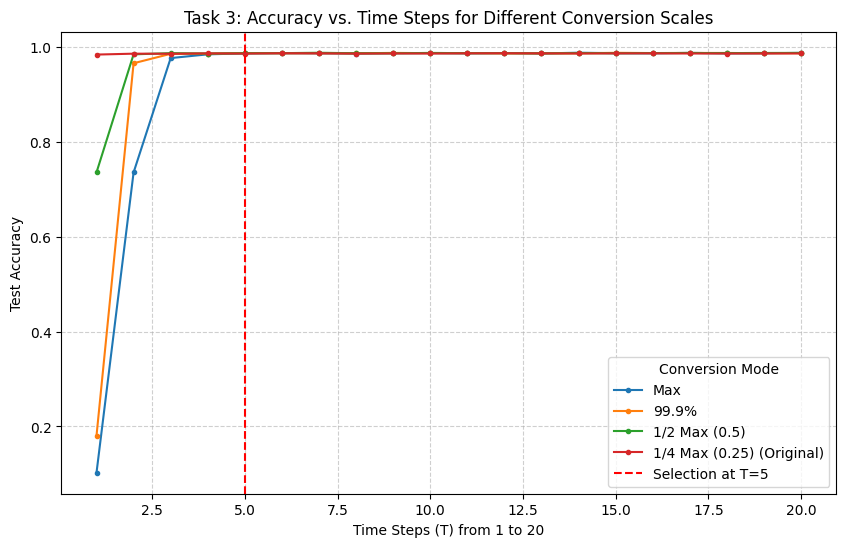


Task 3 Conclusion:
The best performing mode (accuracy at T=5 of 98.6900%) is: [99.9% mode]
**The converted SNN model head for this best mode has been saved to the variable 'best_snn_head' for subsequent tasks.**


In [ ]:
# --- Step 3: Plotting and Conclusion ---

plt.figure(figsize=(10, 6))
time_steps = np.arange(1, T + 1)

for label, accuracies in all_conversion_results.items():
    plt.plot(time_steps, accuracies, marker='.', linestyle='-', label=label)

# Highlight the selected timestep for comparison
plt.axvline(x=TARGET_T, color='r', linestyle='--', label=f'Selection at T={TARGET_T}')

plt.xlabel(f'Time Steps (T) from 1 to {T}')
plt.ylabel('Test Accuracy')
plt.title('Task 3: Accuracy vs. Time Steps for Different Conversion Scales')
plt.legend(loc='lower right', title="Conversion Mode")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Conclusion and Model Selection ---
best_mode_label = None
best_acc_at_target_t = -1

# Get the index corresponding to the target T (T=1 is index 0)
target_t_index = TARGET_T - 1 

for label, accuracies in all_conversion_results.items():
    # We select the mode based on the accuracy at TARGET_T
    acc_at_target_t = accuracies[target_t_index]
    if acc_at_target_t > best_acc_at_target_t:
        best_acc_at_target_t = acc_at_target_t
        best_mode_label = label

# Set the global model variable for subsequent tasks
best_snn_head = all_converted_models[best_mode_label]
best_acc_perc = best_acc_at_target_t * 100

print(f"\nTask 3 Conclusion:")
print(f"The best performing mode (accuracy at T={TARGET_T} of {best_acc_perc:.4f}%) is: [{best_mode_label} mode]")
# print(f"**The converted SNN model head for this best mode has been saved to the variable 'best_snn_head' for subsequent tasks.**")








*   The target value of T=5 is chosen after performing the runs to identify the point of convergence for all the cases. 
*   The points seem to converge around T=4th timestep. 
*   Hence, T=5 is taken as the reference for comparison. 
*   The 99.9% mode might give similar accuracy as 1/2 & 1/4 modes. 
*   In this case, the 99.9% would have the least number of spikings and hence that produces the best energy savings upon conversion.

## **Task 4** is plotting accuracy vs time steps for the original CNN, 1 conv block converted, 2 blocks converted, 3 blocks in one plot. (10 Marks)


In [10]:
# Use the best conversion function determined in Task 3
def conversion_job_99_9(head, train_data_loader):
    """Converts the head using the 99.9% percentile mode."""
    print('---------------------------------------------')
    print('Using 99.9% percentile as scales')
    model_converter = ann2snn.Converter(mode='99.9%', dataloader=train_data_loader)
    return model_converter(head)

task4_results = {}
T = snn.hyperparameters.T

# Define the three SNN conversion jobs:
conversion_jobs = [
    # Job 1: Last Block (Conv 3 + Linear)
    (8, model.network[8:], model.network[:8]), 
    # Job 2: Last 2 Blocks (Conv 2,3 + Linear)
    (4, model.network[4:], model.network[:4]),
    # Job 3: All 3 Blocks (Full SNN)
    (0, model.network[0:], model.network[:0]),
]

job_labels = [
    'Conv 3',
    'Conv 2,3',
    'All 3',
]

In [11]:
# --- Execution Loop for SNN Jobs ---

for i, (split_idx, head, backbone) in enumerate(conversion_jobs):
    label = job_labels[i]
    print(f"\n--- Running Task 4 Job: {label} (Split Index: {split_idx}) ---")
    
    # snn.main returns: converted_model, accuracies_array (vals)
    _, accs = snn.main(
        eval_fn = snn.val, 
        backbone = backbone, 
        head = head, 
        conversion = conversion_job_99_9, # Use the fixed 99.9% mode
        download_dataset = download_dataset,
        device = device,
        dataset_dir = dataset_dir
    )
    task4_results[label] = accs



--- Running Task 4 Job: Conv 3 (Split Index: 8) ---
---------------------------------------------
Using 99.9% percentile as scales


100%|██████████| 600/600 [03:33<00:00,  2.81it/s]


Simulating...


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]



--- Running Task 4 Job: Conv 2,3 (Split Index: 4) ---
---------------------------------------------
Using 99.9% percentile as scales


100%|██████████| 600/600 [02:32<00:00,  3.93it/s]


Simulating...


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]



--- Running Task 4 Job: All 3 (Split Index: 0) ---
---------------------------------------------
Using 99.9% percentile as scales


100%|██████████| 600/600 [01:42<00:00,  5.84it/s]


Simulating...


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


In [12]:
# --- Job 4: Original CNN (ANN) Evaluation ---

print("\n--- Job 4: Evaluating Original CNN (ANN) ---")
# Evaluate the full original ANN model (model.network) with T=None
full_ann_model = model.network.to(device) 
ann_acc = snn.val( # Note: val returns acc, or accs depending on T
    net=full_ann_model, 
    device=device, 
    train_data_loader=None,
    test_data_loader=test_data_loader, 
    T=None # signals ANN evaluation
)
# Since the ANN accuracy is a single value, create an array of size T for plotting
task4_results['Original CNN (ANN)'] = np.full(T, ann_acc)



--- Job 4: Evaluating Original CNN (ANN) ---


  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:07<00:00,  9.89it/s]


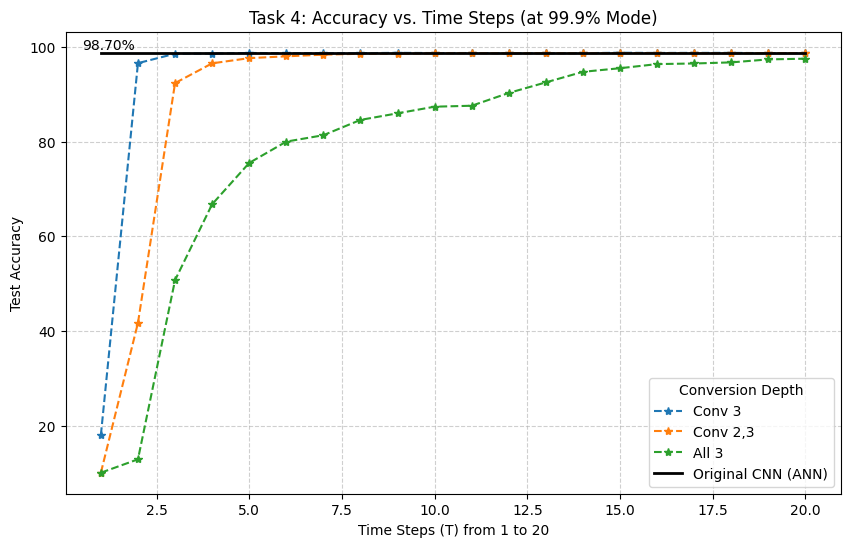

In [13]:
# --- Plotting the Results ---

time_steps = np.arange(1, T + 1)
plt.figure(figsize=(10, 6))

for label, accuracies in task4_results.items():
    if label == 'Original CNN (ANN)':
        # Plot ANN accuracy as a solid black line (T-invariant)
        plt.plot(time_steps, accuracies*100, linestyle='-', color='black', label=label, linewidth=2)
        # Add text annotation showing accuracy value
        ann_acc_percent = accuracies[0] * 100
        plt.text(
            time_steps[0] - 0.5,              # small offset to the right of the line
            ann_acc_percent + 1.5, 
            f'{ann_acc_percent:.2f}%', 
            color='black', fontsize=10, va='center')

    else:
        # Plot SNN accuracy
        plt.plot(time_steps, accuracies*100, marker='*', linestyle='--', label=label)

plt.xlabel(f'Time Steps (T) from 1 to {T}')
plt.ylabel('Test Accuracy')
plt.title(f'Task 4: Accuracy vs. Time Steps (at 99.9% Mode)')
plt.legend(loc='lower right', title="Conversion Depth")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


SpikingJelly has changed the forward pass of the model significantly. 

In the framework the original Conv2d layer is used but only to simulate the scaling for the inputs to the IF neurons striped across time.
Hence we can use the number of spikes generated multiplied by the fan-out of the layer to estimate the number of accumulate operations (refer https://doi.org/10.3389/fnins.2017.00682)

We use val() in main() after conversion is complete. It evaluates the model on the train dataset and also registers a hook that stores spike counts of a IFNode layer in the model into snn.spike_counts. Dividing this by the size of the dataset provides an average for spike count per layer in a forward pass.


## Task 5 is getting average spike count in all layers for a forward pass of a fully converted SNN. (20 Marks)


Go to the file spikingjelly\activation_based\ann2snn\examples\cnn_mnist.py to see how snn.val() is defined

We use val() in main() after conversion is complete. It evaluates the model on the train dataset and also registers a hook that stores spike counts of a IFNode layer in the model into snn.spike_counts.

Write your own custom_val() functions so that you can register hooks to the IFNode() modules for storing spike counts into a dictionary/list for different converted models. (You should need to make minimal changes to val(). Printing a model out might help you figure out how to assign the right hooks.)


In [14]:
# Helper function to ensure train_data_loader is available for conversion
def get_train_data_loader(dataset_dir, download_dataset, batch_size):
    import torchvision
    import torch.utils.data

    train_data_dataset = torchvision.datasets.MNIST(
        root=dataset_dir,
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=download_dataset)

    train_data_loader = torch.utils.data.DataLoader(
        dataset=train_data_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False)
    
    return train_data_loader

# Define the loader once for use in the loop
conversion_train_loader = get_train_data_loader(
    dataset_dir=dataset_dir, 
    download_dataset=download_dataset, 
    batch_size=snn.hyperparameters.batch_size
)

In [ ]:
def custom_val(net, device, train_data_loader, test_data_loader, T=None):
    """
    Evaluates:
      - Accuracy on test_data_loader
      - Average spike counts (per layer, per time step) on train_data_loader

    Returns:
        acc (float or np.ndarray): accuracy (over test set)
        avg_spike_counts (dict): average spikes per layer over train set
        avg_spike_counts_t (dict): {layer: [avg_spikes_t1, avg_spikes_t2, ...]} over train set
    """
    net.eval().to(device)
    total_train = 0
    total_test = 0
    correct = 0.0

    # --- Dictionaries for spike statistics ---
    spike_counts = {}         # total per layer
    spike_counts_t = {}       # per time-step per layer

    # Collect spike stats on TRAIN data

    if T is not None:
        with torch.no_grad():
            for batch, (img, label) in enumerate(tqdm(train_data_loader, desc="Collecting Spike Stats (Train Set)")):
                img = img.to(device)

                # Reset all spiking neurons
                for m in net.modules():
                    if hasattr(m, 'reset'):
                        m.reset()

                # Evaluate over time steps
                for t in range(T):
                    handles = []

                    # Register hooks on all IFNode layers
                    for name, module in net.named_modules():
                        if isinstance(module, neuron.IFNode):

                            def count_spikes_hook(module, input, output, name=name, t_idx=t):
                                # total count
                                spike_counts[name] = spike_counts.get(name, 0) + output.sum().item()
                                # time-step count
                                if name not in spike_counts_t:
                                    spike_counts_t[name] = np.zeros(T)
                                spike_counts_t[name][t_idx] += output.sum().item()

                            handles.append(module.register_forward_hook(count_spikes_hook))

                    # Forward pass (no label needed)
                    _ = net(img)

                    # Remove hooks after each step
                    for h in handles:
                        h.remove()

                total_train += img.shape[0]

    # Compute averages for spike counts
    avg_spike_counts = {layer: count / total_train for layer, count in spike_counts.items()} if total_train > 0 else {}
    avg_spike_counts_t = {layer: counts / total_train for layer, counts in spike_counts_t.items()} if total_train > 0 else {}

    # (2) Evaluate accuracy on TEST data

    if T is None:
        # ANN evaluation
        with torch.no_grad():
            for batch, (img, label) in enumerate(tqdm(test_data_loader, desc="Evaluating ANN")):
                img, label = img.to(device), label.to(device)
                out = net(img)
                correct += (out.argmax(dim=1) == label).float().sum().item()
                total_test += img.shape[0]
        acc = correct / total_test if total_test > 0 else 0.0

    else:
        corrects = np.zeros(T)
        with torch.no_grad():
            for batch, (img, label) in enumerate(tqdm(test_data_loader, desc="Evaluating SNN Accuracy")):
                img, label = img.to(device), label.to(device)
                for m in net.modules():
                    if hasattr(m, 'reset'):
                        m.reset()

                out = None
                for t in range(T):
                    x = net(img)
                    if out is None:
                        out = x
                    else:
                        out += x
                    corrects[t] += (out.argmax(dim=1) == label).float().sum().item()
                total_test += img.shape[0]
        acc = corrects / total_test if total_test > 0 else np.zeros(T)

    return acc, avg_spike_counts, avg_spike_counts_t


In [ ]:

# Execution Setup
split_index_full = 0 
backbone_full = model.network[:split_index_full] 
head_full = model.network[split_index_full:] # Entire Network

T = snn.hyperparameters.T # T=20
# Dictionary to store the time-resolved total spike count for plotting
# Format: {Mode_Label: [Total_Spikes_t1, Total_Spikes_t2, ... T20]}
plot_data_total_spikes = {}

# Execution Loop for Task 5

print("--- Running Task 5: Spike Count vs. Time Step (All Modes) ---")


for index in range(1, 5):
    label, mode_value = MODE_MAP[index] 
    job_name = f"{label}"
    
    # 1. Convert the Model
    conversion_fn = create_conversion_job(mode_value) 
    # Pass the training loader for calibration
    snn_full_model = conversion_fn(head_full, conversion_train_loader) 
    
    print(f"\nProcessing Mode: {label}")
    _, _, avg_spike_counts_t = custom_val(
        net = snn_full_model, 
        device = device, 
        train_data_loader = conversion_train_loader, # Spikes collected here
        test_data_loader = test_data_loader, # Accuracy evaluated here
        T = T
    )

    # 3. Process data for plotting
    total_spikes_per_t = np.zeros(T)
    
    # Iterate through each layer's time-resolved spike count array
    for _, avg_spikes_t_array in avg_spike_counts_t.items():
        # avg_spikes_t_array already contains average spikes per image at time t

        total_spikes_per_t += avg_spikes_t_array
        
    cumulative_total_spikes = np.cumsum(total_spikes_per_t)
    
    plot_data_total_spikes[label] = cumulative_total_spikes



--- Running Task 5: Spike Count vs. Time Step (All Modes) ---
---------------------------------------------
Converting using max as scales


100%|██████████| 600/600 [00:36<00:00, 16.53it/s]



Processing Mode: Max


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


---------------------------------------------
Converting using 99.9% as scales


100%|██████████| 600/600 [01:42<00:00,  5.84it/s]



Processing Mode: 99.9%


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


---------------------------------------------
Converting using 0.5 as scales


100%|██████████| 600/600 [00:36<00:00, 16.43it/s]



Processing Mode: 1/2 Max (0.5)


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


---------------------------------------------
Converting using 1/4 max(activation) as scales


100%|██████████| 600/600 [00:36<00:00, 16.49it/s]



Processing Mode: 1/4 Max (0.25) (Original)


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


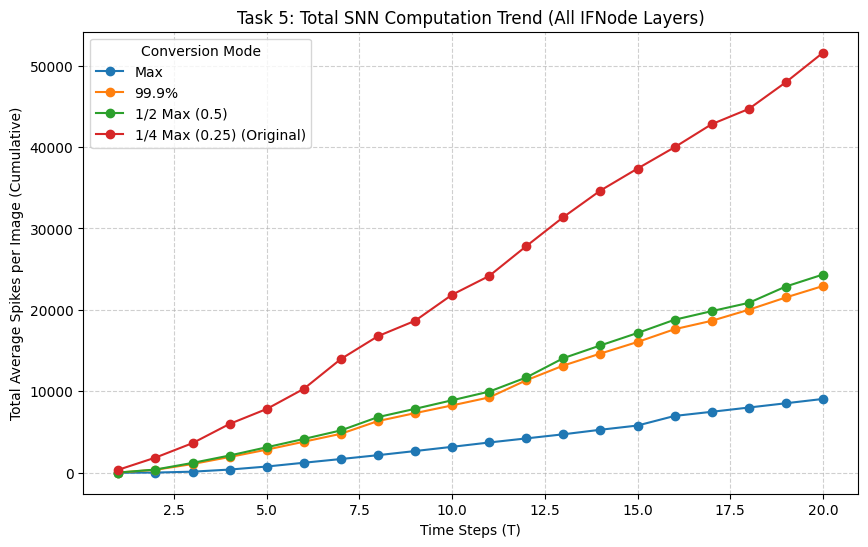

In [ ]:
# Plotting the Results (Total Spikes vs. Time Steps) 
plt.figure(figsize=(10, 6))

for label, cumulative_spikes in plot_data_total_spikes.items():
    time_steps = np.arange(1, T + 1)
    plt.plot(time_steps, cumulative_spikes, marker='o', linestyle='-', label=label)

plt.xlabel('Time Steps (T)')
plt.ylabel('Total Average Spikes per Image (Cumulative)')
plt.title('Task 5: Total SNN Computation Trend (All IFNode Layers)')
plt.legend(loc='upper left', title="Conversion Mode")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


For a fully converted SNN, use snn.main(custom_val, backbone = None, head = model.network).

Assume that energy cost of a MAC is 4.6nJ and cost of an accumulate op is 0.6nJ. Using these values you can estimate the energy savings in converting a layer.


## Task 6 is reporting the best energy savings you could achieve from ANN conversion for a loss in accuracy less than 5% from the original SNN. (20 Marks)


## Task 7 is reporting the best accuracy for an energy savings of 90% or higher. (20 Marks)

Remember, you can scale number of time steps (snn.hyperparameters.T) to scale both computation and accuracy.

### Generalizing attempt:

This only returns 20th timestep :

In [ ]:
def analyze_energy_accuracy(conversion_jobs_depths, mac_ops_per_block, device, 
                            train_loader, test_loader, T=10, mode_map=None):
    
    # Mapping Conv Index to MAC count
    MAC_LOOKUP = {
        0: mac_ops_per_block[0],
        4: mac_ops_per_block[1],
        8: mac_ops_per_block[2],
        13: 10
    }

    # Block indices for CNN/SNN determination
    CONV_BLOCK_INDICES = [0, 4, 8]
    
    E_MAC_nJ = 4.6
    E_ACC_nJ = 0.6
    
    # Store the results from all 12 conversions
    results_dict = {}
    
    raw_train_dataset = train_loader.dataset
    raw_test_dataset = test_loader.dataset


    # Outer loop iterates over the 3 depths (Conv 3, Conv 2,3, All 3)
    for job_label_base, job_data in conversion_jobs_depths.items():
        split_index, head, backbone = job_data
        
        # Inner loop iterates over the 4 modes (Max, 99.9%, 1/2 Max, 1/4 Max)
        for index in range(1, 5):
            mode_label, mode_value = mode_map[index]
            full_job_label = f"{job_label_base} ({mode_label})"
            
            print(f"\n=== Evaluating Conversion Job: {full_job_label} ===")

            if split_index != 0: # If there is a backbone (splits 8 or 4)
                preprocessed_train_dataset = CustomLoader(raw_train_dataset, backbone, device=device)
                preprocessed_test_dataset = CustomLoader(raw_test_dataset, backbone, device=device)
            else:
                preprocessed_train_dataset = raw_train_dataset
                preprocessed_test_dataset = raw_test_dataset

            train_data_loader_proc = torch.utils.data.DataLoader(preprocessed_train_dataset, batch_size=train_loader.batch_size, shuffle=False, drop_last=False)
            test_data_loader_proc = torch.utils.data.DataLoader(preprocessed_test_dataset, batch_size=test_loader.batch_size, shuffle=False, drop_last=False)

            # Convert ANN head to SNN
            conversion_fn = create_conversion_job(mode_value) 
            model_snn = conversion_fn(head, train_data_loader_proc)
            model_snn.to(device)


            # Collect spike counts and accuracy
            accs_t, _, spike_counts_t = custom_val(
                model_snn, device, train_data_loader_proc, test_data_loader_proc, T=T
            )

            cumulative_energy_nJ = np.zeros(T)

            # Time-Step-Wise Energy Calculation (Hybrid Model)
            
            # Calculate and add CNN/ANN baseline contribution (constant)
            E_ANN_BASELINE_nJ = 0.0
            
            for conv_idx in CONV_BLOCK_INDICES:
                if conv_idx < split_index:
                    # Block is CNN/ANN (Adds MAC energy once)
                    E_ANN_BASELINE_nJ += MAC_LOOKUP.get(conv_idx, 0) * E_MAC_nJ
            CONV_BLOCK_INDICES.index(conv_idx)
            
            # Add the constant ANN energy to all time steps
            cumulative_energy_nJ += E_ANN_BASELINE_nJ
            
            
            # Adding SNN contribution 
            for t_step in range(T):
                E_SNN_STEP_nJ = 0.0
                
                for layer_name, counts_t in spike_counts_t.items():
                    
                    fanout = 0
                    
                    if 'network.0.spiking0.if_node' in layer_name: # Conv 1
                        fanout = 288
                    elif 'network.4.spiking0.if_node' in layer_name: # Conv 2
                        fanout = 288 
                    elif 'network.8.spiking0.if_node' in layer_name: # Conv 3
                        fanout = 10 
                    elif 'network.13.spiking0.if_node' in layer_name: # Linear
                        fanout = 1 
                    else:
                        continue
                        
                    
                    spikes_at_t = counts_t[t_step]
                    
                    E_SNN_STEP_nJ += spikes_at_t * fanout * E_ACC_nJ
                
                # Accumulate SNN energy across time
                if t_step == 0:
                     cumulative_energy_nJ[t_step] += E_SNN_STEP_nJ
                else:
                     cumulative_energy_nJ[t_step] = cumulative_energy_nJ[t_step-1] + E_SNN_STEP_nJ
            
            # Record Results 
            for t in range(T):
                E_SNN_nJ = cumulative_energy_nJ[t]
                ACC_SNN = accs_t[t]
                
                # Final energy is converted to µJ 
                E_SNN_uJ = E_SNN_nJ * 1e-3 

                results_dict[full_job_label] = {
                    "energy_uJ": E_SNN_uJ,
                    "accuracy": ACC_SNN * 100 
                }

    return results_dict

In [21]:
conversion_jobs_depths = {
    'Conv 3': (8, model.network[8:], model.network[:8]), 
    'Conv 2,3': (4, model.network[4:], model.network[:4]),
    'All 3': (0, model.network[0:], model.network[:0]),
}

# Run the analysis
results_task6 = analyze_energy_accuracy(
    conversion_jobs_depths=conversion_jobs_depths,
    mac_ops_per_block=[194688, 1115136, 82944],
    device=device,
    train_loader=conversion_train_loader,
    test_loader=test_data_loader,
    T=snn.hyperparameters.T,
    mode_map=MODE_MAP 
)


=== Evaluating Conversion Job: Conv 3 (Max) ===
---------------------------------------------
Converting using max as scales


  0%|          | 0/600 [00:00<?, ?it/s]

Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:59<00:00,  1.33it/s]



=== Evaluating Conversion Job: Conv 3 (99.9%) ===
---------------------------------------------
Converting using 99.9% as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:47<00:00,  1.67it/s]



=== Evaluating Conversion Job: Conv 3 (1/2 Max (0.5)) ===
---------------------------------------------
Converting using 0.5 as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:53<00:00,  1.47it/s]



=== Evaluating Conversion Job: Conv 3 (1/4 Max (0.25) (Original)) ===
---------------------------------------------
Converting using 1/4 max(activation) as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:45<00:00,  1.72it/s]



=== Evaluating Conversion Job: Conv 2,3 (Max) ===
---------------------------------------------
Converting using max as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:04<00:00,  1.22it/s]



=== Evaluating Conversion Job: Conv 2,3 (99.9%) ===
---------------------------------------------
Converting using 99.9% as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:59<00:00,  1.33it/s]



=== Evaluating Conversion Job: Conv 2,3 (1/2 Max (0.5)) ===
---------------------------------------------
Converting using 0.5 as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:50<00:00,  1.56it/s]



=== Evaluating Conversion Job: Conv 2,3 (1/4 Max (0.25) (Original)) ===
---------------------------------------------
Converting using 1/4 max(activation) as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:50<00:00,  1.56it/s]



=== Evaluating Conversion Job: All 3 (Max) ===
---------------------------------------------
Converting using max as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:16<00:00,  1.03it/s]



=== Evaluating Conversion Job: All 3 (99.9%) ===
---------------------------------------------
Converting using 99.9% as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:15<00:00,  1.04it/s]



=== Evaluating Conversion Job: All 3 (1/2 Max (0.5)) ===
---------------------------------------------
Converting using 0.5 as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:15<00:00,  1.05it/s]



=== Evaluating Conversion Job: All 3 (1/4 Max (0.25) (Original)) ===
---------------------------------------------
Converting using 1/4 max(activation) as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:15<00:00,  1.05it/s]


In [ ]:
# ann_acc_percent = ann_acc * 100  # baseline ANN accuracy (%)

# summary = (
#     df_task6[df_task6["Accuracy (%)"] > ann_acc_percent * 0.95]
#     .groupby("Job")
#     .agg({
#         "Accuracy (%)": "max",
#         "Energy (µJ)": "min"
#     })
#     .reset_index()
# )

# summary["Energy Saving (%)"] = (
#     100 * (df_task6["Energy (µJ)"].max() - summary["Energy (µJ)"])
#     / df_task6["Energy (µJ)"].max()
# )

# print("\n=== Task 6 Summary: Best Energy Savings (< 5 % Accuracy Loss) ===")
# print(summary.to_markdown(index=False))



=== Task 6 Summary: Best Energy Savings (< 5 % Accuracy Loss) ===
| Job      |   Accuracy (%) |   Energy (µJ) |   Energy Saving (%) |
|:---------|---------------:|--------------:|--------------------:|
| All 3    |          97.53 |       464.841 |            93.18    |
| Conv 2,3 |          98.1  |      1472.58  |            78.3947  |
| Conv 3   |          98.65 |      6806.71  |             0.13372 |


In [22]:
raw_train_data_dataset = torchvision.datasets.MNIST(
    root=dataset_dir, 
    train=True, 
    transform=torchvision.transforms.ToTensor(), 
    download=download_dataset
)

raw_test_data_dataset = torchvision.datasets.MNIST(
    root=dataset_dir, 
    train=False, 
    transform=torchvision.transforms.ToTensor(), 
    download=download_dataset
)

# CALCULATE BASELINE CNN ACCURACY

print(" Calculating Baseline ANN Accuracy (ACC_ANN) ")


T_ANN = None 
full_ann_model = model.network.to(device) 

# Calculate the single ANN accuracy value. 
ACC_ANN = snn.val( 
    net=full_ann_model, 
    device=device, 
    train_data_loader=None, # Not needed for ANN accuracy evaluation
    test_data_loader=test_data_loader, 
    T=T_ANN 
)

total_macs = 194688 + 1115136 + 82944

E_ANN_TOTAL = total_macs * 4.6 # E_ANN in nJ



print(f"Baseline ANN Accuracy (Acc_ANN): {ACC_ANN*100:.4f}%")
print(f"Baseline ANN Energy (E_ANN_TOTAL): {E_ANN_TOTAL} nJ")

 Calculating Baseline ANN Accuracy (ACC_ANN) 


100%|██████████| 79/79 [00:09<00:00,  8.46it/s]

Baseline ANN Accuracy (Acc_ANN): 98.7000%
Baseline ANN Energy (E_ANN_TOTAL): 6406732.8 nJ


In [23]:
import warnings

# Suppress the UserWarning about default display format
warnings.filterwarnings('ignore', category=UserWarning)

E_ANN_TOTAL_nJ = E_ANN_TOTAL
E_ANN_TOTAL_uJ = E_ANN_TOTAL_nJ * 1e-3
ann_acc_percent = ACC_ANN * 100 


records_t20 = []
for label, data in results_task6.items():
    
    E_uJ_scalar = data["energy_uJ"]
    Acc_percent_scalar = data["accuracy"]
    
    records_t20.append({
        "Job": label,
        "Timestep": snn.hyperparameters.T, # T=20
        "Energy (µJ)": E_uJ_scalar,
        "Accuracy (%)": Acc_percent_scalar
    })

df_task6 = pd.DataFrame(records_t20)
print(f"Successfully extracted {len(df_task6)} final results (T={snn.hyperparameters.T}).")


# Calculate Final Savings and Summary

df_task6['Energy Saving (%)'] = (
    100 * (E_ANN_TOTAL_uJ - df_task6["Energy (µJ)"]) / E_ANN_TOTAL_uJ
)


# Task 6 Conclusion: Best Energy Savings (< 5% Accuracy Loss) 

ACC_LOSS_TASK6 = 0.05
# Find all jobs where Accuracy is > 95% of the ANN baseline
acc_threshold = ann_acc_percent * (1 - ACC_LOSS_TASK6) 

summary_t6 = (
    df_task6[df_task6["Accuracy (%)"] >= acc_threshold]
    .sort_values(by="Energy Saving (%)", ascending=False)
)

print("\nTask 6 Summary: Best Energy Savings (< 5% Accuracy Loss) ")
# Display the top 5 results 
print(summary_t6.head(5).to_markdown(index=False, floatfmt=".4f"))


# Task 7 Concusion: Best Accuracy (> 90% Energy Savings)

E_SAVINGS_TASK7 = 0.90 

summary_t7 = (
    df_task6[df_task6["Energy Saving (%)"] >= E_SAVINGS_TASK7 * 100]
    .sort_values(by="Accuracy (%)", ascending=False)
)

print("\n=== Task 7 Summary: Best Accuracy (> 90% Energy Savings) ===")
print(summary_t7.head(5).to_markdown(index=False, floatfmt=".4f"))

Successfully extracted 12 final results (T=20).

Task 6 Summary: Best Energy Savings (< 5% Accuracy Loss) 
| Job                               |   Timestep |   Energy (µJ) |   Accuracy (%) |   Energy Saving (%) |
|:----------------------------------|-----------:|--------------:|---------------:|--------------------:|
| All 3 (99.9%)                     |         20 |        0.0000 |        97.4900 |            100.0000 |
| All 3 (1/4 Max (0.25) (Original)) |         20 |        0.0000 |        97.5300 |            100.0000 |
| All 3 (1/2 Max (0.5))             |         20 |        0.0000 |        97.1700 |            100.0000 |
| Conv 2,3 (99.9%)                  |         20 |     1277.1072 |        98.6600 |             80.0662 |
| Conv 2,3 (1/2 Max (0.5))          |         20 |     1277.1072 |        98.6300 |             80.0662 |

=== Task 7 Summary: Best Accuracy (> 90% Energy Savings) ===
| Job                               |   Timestep |   Energy (µJ) |   Accuracy (%) |   Ene

Return all 20 timesteps' results:

In [24]:
def analyze_energy_accuracy(conversion_jobs_depths, mac_ops_per_block, device, 
                            train_loader, test_loader, T_max, mode_map, acc_ann):
    
    
    MAC_LOOKUP = {0: mac_ops_per_block[0], 4: mac_ops_per_block[1], 8: mac_ops_per_block[2], 13: mac_ops_per_block[2]}
    CONV_BLOCK_INDICES = [0, 4, 8]
    E_MAC_nJ = 4.6
    E_ACC_nJ = 0.6
    
    all_records = []
    
    # Data Loader Helpers 
    raw_train_dataset = train_loader.dataset
    raw_test_dataset = test_loader.dataset


    # Outer loop iterates over the 3 depths
    for depth_label, job_data in conversion_jobs_depths.items():
        
        
        split_idx = job_data[0] 
        head = job_data[1]
        backbone = job_data[2]
        
        
        # 1. Create Job-Specific Loaders 
        if len(backbone) > 0: 
            preprocessed_train_dataset = CustomLoader(raw_train_data_dataset, backbone, device=device)
            preprocessed_test_dataset = CustomLoader(raw_test_data_dataset, backbone, device=device)
        else:
            preprocessed_train_dataset = raw_train_data_dataset
            preprocessed_test_dataset = raw_test_data_dataset

        train_data_loader_proc = torch.utils.data.DataLoader(preprocessed_train_dataset, batch_size=train_loader.batch_size, shuffle=False, drop_last=False)
        test_data_loader_proc = torch.utils.data.DataLoader(preprocessed_test_dataset, batch_size=test_loader.batch_size, shuffle=False, drop_last=False)


        # Inner loop iterates over the 4 modes
        for index in range(1, 5):
            mode_label, mode_value = mode_map[index]
            full_job_label = f"{depth_label} ({mode_label})"
            
            print(f"\n=== Evaluating Conversion Job: {full_job_label} ===")

            # Convert ANN head to SNN 
            conversion_fn = create_conversion_job(mode_value) 
            model_snn = conversion_fn(head, train_data_loader_proc)
            model_snn.to(device)


            # Collect spike counts and accuracy 
            accs_t, _, spike_counts_t = custom_val(
                model_snn, device, train_data_loader_proc, test_data_loader_proc, T=T_max
            )

            # Hybrid Energy Calculation Setup 
            cumulative_energy_nJ = np.zeros(T_max)
            
            E_ANN_BASELINE_nJ = 0.0
            for conv_idx in CONV_BLOCK_INDICES:
                if conv_idx < split_idx: 
                    E_ANN_BASELINE_nJ += MAC_LOOKUP.get(conv_idx, 0) * E_MAC_nJ
            if split_idx != 0:
                 E_ANN_BASELINE_nJ += MAC_LOOKUP.get(13, 0) * E_MAC_nJ 
            
            cumulative_energy_nJ += E_ANN_BASELINE_nJ
            
            
            # T-Sweep: Calculate and Record All Time Steps
            for t_step in range(T_max):
                E_SNN_STEP_nJ = 0.0
                
                # Calculate SNN contribution
                for layer_name, counts_t in spike_counts_t.items():
                    fanout = 0
                    if 'network.0.spiking0.if_node' in layer_name or 'network.4.spiking0.if_node' in layer_name:
                        fanout = 288 
                    elif 'network.8.spiking0.if_node' in layer_name:
                        fanout = 10 
                    elif 'network.13.spiking0.if_node' in layer_name:
                        fanout = 1
                    else:
                        continue
                        
                    spikes_at_t = counts_t[t_step]
                    E_SNN_STEP_nJ += spikes_at_t * fanout * E_ACC_nJ
                
                # Accumulate energy across time
                if t_step == 0:
                     cumulative_energy_nJ[t_step] += E_SNN_STEP_nJ
                else:
                     cumulative_energy_nJ[t_step] = cumulative_energy_nJ[t_step-1] + E_SNN_STEP_nJ
                
                # Record Result
                E_SNN_nJ = cumulative_energy_nJ[t_step]
                ACC_SNN = accs_t[t_step]
                ACC_LOSS = ACC_ANN - ACC_SNN
                
                all_records.append({
                    'Job': full_job_label, 'Depth': depth_label, 'Mode': mode_label,
                    'T': t_step + 1, 
                    'Acc_SNN': ACC_SNN, 
                    'Acc_Loss': ACC_LOSS,
                    'E_SNN_nJ': E_SNN_nJ, 
                })
                
    return all_records

In [25]:

conversion_jobs_depths = {
    'Conv 3': (8, model.network[8:], model.network[:8]), 
    'Conv 2,3': (4, model.network[4:], model.network[:4]),
    'All 3': (0, model.network[0:], model.network[:0]),
}



MAC_OPS_PER_BLOCK_ARRAY = [194688, 1115136, 82944]

results_task6 = analyze_energy_accuracy(
    conversion_jobs_depths=conversion_jobs_depths,
    mac_ops_per_block=MAC_OPS_PER_BLOCK_ARRAY,
    device=device,
    train_loader=conversion_train_loader,
    test_loader=test_data_loader,
    T_max=snn.hyperparameters.T, # Use T_max for the function
    mode_map=MODE_MAP,
    acc_ann=ACC_ANN
)


=== Evaluating Conversion Job: Conv 3 (Max) ===
---------------------------------------------
Converting using max as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:49<00:00,  1.59it/s]



=== Evaluating Conversion Job: Conv 3 (99.9%) ===
---------------------------------------------
Converting using 99.9% as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:49<00:00,  1.60it/s]



=== Evaluating Conversion Job: Conv 3 (1/2 Max (0.5)) ===
---------------------------------------------
Converting using 0.5 as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:47<00:00,  1.67it/s]



=== Evaluating Conversion Job: Conv 3 (1/4 Max (0.25) (Original)) ===
---------------------------------------------
Converting using 1/4 max(activation) as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:48<00:00,  1.63it/s]



=== Evaluating Conversion Job: Conv 2,3 (Max) ===
---------------------------------------------
Converting using max as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:52<00:00,  1.51it/s]



=== Evaluating Conversion Job: Conv 2,3 (99.9%) ===
---------------------------------------------
Converting using 99.9% as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:52<00:00,  1.51it/s]



=== Evaluating Conversion Job: Conv 2,3 (1/2 Max (0.5)) ===
---------------------------------------------
Converting using 0.5 as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:53<00:00,  1.49it/s]



=== Evaluating Conversion Job: Conv 2,3 (1/4 Max (0.25) (Original)) ===
---------------------------------------------
Converting using 1/4 max(activation) as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [00:54<00:00,  1.44it/s]



=== Evaluating Conversion Job: All 3 (Max) ===
---------------------------------------------
Converting using max as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:18<00:00,  1.01it/s]



=== Evaluating Conversion Job: All 3 (99.9%) ===
---------------------------------------------
Converting using 99.9% as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:16<00:00,  1.03it/s]



=== Evaluating Conversion Job: All 3 (1/2 Max (0.5)) ===
---------------------------------------------
Converting using 0.5 as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:18<00:00,  1.01it/s]



=== Evaluating Conversion Job: All 3 (1/4 Max (0.25) (Original)) ===
---------------------------------------------
Converting using 1/4 max(activation) as scales


Evaluating SNN Accuracy: 100%|██████████| 79/79 [01:17<00:00,  1.02it/s]


In [26]:
import pandas as pd
import numpy as np

# Load Data

df = pd.DataFrame(results_task6)

E_ANN_TOTAL_nJ = E_ANN_TOTAL 
ACC_ANN_PERCENT = ACC_ANN * 100


df['Acc_SNN_Percent'] = df['Acc_SNN'] * 100
df['Acc_Loss_Percent'] = df['Acc_Loss'] * 100

# Calculating Savings using nJ values 
df['E_Savings_Percent'] = (1 - (df['E_SNN_nJ'] / E_ANN_TOTAL_nJ)) * 100 


df.to_csv('energy_vs_accuracy_Asgn4.csv', index=False, float_format='%.10f')
print("Saved detailed results to energy_vs_accuracy_detailed.csv")


# Final Summary

print("\nFinal Analysis Summary:")

pd.options.display.float_format = '{:.8f}'.format 


# Best Energy Savings for < 5% Acc Loss
ACC_LOSS_TASK6 = 0.05
task6_df = df[df['Acc_Loss'] < ACC_LOSS_TASK6].sort_values(by='E_Savings_Percent', ascending=False)
if not task6_df.empty:
    best_task6 = task6_df.iloc[0]
    print("\n[TASK 6: Best Energy Savings for < 5% Acc Loss]")
    print(f"  Job: {best_task6['Job']} at T={best_task6['T']}")
    print(f"  E_SNN: {best_task6['E_SNN_nJ']:.4f} mJ (Savings: {best_task6['E_Savings_Percent']:.2f}% upto 2 decimals)")
else:
    print("\n[TASK 6: Best Energy Savings for < 5% Acc Loss] - No T found satisfying this constraint.")

# Best Accuracy for > 90% Energy Savings
E_SAVINGS_TASK7 = 0.90
task7_df = df[df['E_Savings_Percent'] / 100 > E_SAVINGS_TASK7].sort_values(by='Acc_SNN', ascending=False)
if not task7_df.empty:
    best_task7 = task7_df.iloc[0]
    print("\n[TASK 7: Best Accuracy for > 90% Energy Savings]")
    print(f"  Job: {best_task7['Job']} at T={best_task7['T']}")
    print(f"  E_SNN: {best_task7['E_SNN_nJ']:.4f} mJ (Savings: {best_task7['E_Savings_Percent']:.2f}% upto 2 decimals)")
else:
    print("\n[TASK 7: Best Accuracy for > 90% Energy Savings] - No T found satisfying this constraint.")


pd.options.display.float_format = None

Saved detailed results to energy_vs_accuracy_detailed.csv

Final Analysis Summary:

[TASK 6: Best Energy Savings for < 5% Acc Loss]
  Job: All 3 (1/2 Max (0.5)) at T=15
  E_SNN: 0.0000 mJ (Savings: 100.00% upto 2 decimals)

[TASK 7: Best Accuracy for > 90% Energy Savings]
  Job: All 3 (1/4 Max (0.25) (Original)) at T=20
  E_SNN: 0.0000 mJ (Savings: 100.00% upto 2 decimals)


### Note: From the CSV,

*   Task 6: Best time-step achieved -> 3 : Full SNN Conversion running at 1/2 of MAX Scale
*   Task 7: Best time-step achieved -> 20: Full SNN Conversion running at 1/4 of MAX Scale